In [21]:
import pycuda.autoinit
import pycuda.driver as drv
import numpy as np
from pycuda import gpuarray
from pycuda.compiler import SourceModule
from IPython.display import Image

Установим начальное расположение токенов игры.  
Каждый токен это значение от 1 до 16


0  1  2  3
4  5  6  7
8  9  10 11
12 13 14 15
    


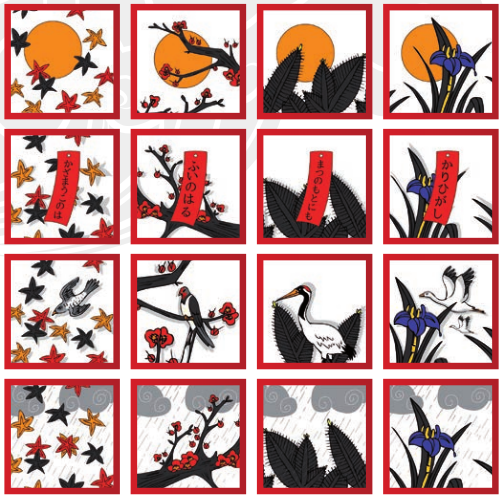

In [24]:
print("""
0  1  2  3
4  5  6  7
8  9  10 11
12 13 14 15
    """)
Image("tokens.png")

Располагаются токены в массиве размером 16 элементов.  
Обозначим, с какими карточками каждая карта может быть связана. Каждой карте соответствует массив карт.

In [ ]:
token_relations = [
    [1,2,3,4,5,8,12],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    []
]

# 16

In [2]:
ker = SourceModule("""
__device__ bool win_combination(int i)
{
    int win[17]={
    61440, // row 0
    3840,  // row 1
    240,   // row 2
    15,    // row 3
    34952, // col 0
    17476, // col 1
    8738,  // col 2
    4369,  // col 3
    52224, // quad 0
    26112, // quad 1
    13056, // quad 2
    3264,  // quad 3
    1632,  // quad 4
    816,   // quad 5
    204,   // quad 6
    102,   // quad 7
    51     // quad 8
    };
    for (int a=0;a<17;a++) if ((i&win[a])==win[a]) return(true);    
    return(false);
}

__global__ void last_turn(float *outvec)
{
    int ones = 0;
    int a = 0;
    
    // Идентификатор блока-потока
    int i = threadIdx.x + blockIdx.x * blockDim.x;
    
    // Убедимся, что число единиц и нулей в комбинации одинаково
    for(a=0;a<16;a++) if ((((int)round(pow(2,a)))&i)>0) ones++;
    
    // Проверим, победна ли комбинация среди возможных
    if (ones==8 && win_combination(i)) outvec[i] = 1;
}
""")

In [3]:
combination_check_gpu = ker.get_function("last_turn")

combinations = np.zeros(256*256).astype(np.float32)
combinations_gpu_out = gpuarray.to_gpu(combinations)

%time combination_check_gpu( combinations_gpu_out, block=(256,1,1), grid=(256,1,1))

CPU times: user 1.19 ms, sys: 0 ns, total: 1.19 ms
Wall time: 1.26 ms


In [4]:
out_combinations = combinations_gpu_out.get()
print('Количество победных комбинаций:', np.count_nonzero(out_combinations))

Количество победных комбинаций: 6315


Посмотрим, на некоторые победные комбинации.

In [5]:
def bin_interpretation(i):
    clear_bin = bin(i)[2:]
    lead_zeros = ''.join(['0' for z in range(16-len(clear_bin))])
    return lead_zeros+clear_bin

In [6]:
for i in np.where(out_combinations == 1)[0][:3]:
    row = []
    i_bin = bin_interpretation(i)
    row.append(i_bin[:4])
    row.append(i_bin[4:8])
    row.append(i_bin[8:12])
    row.append(i_bin[12:])
    print('\n')
    for r in row:
        print(r)



0000
0000
1111
1111


0000
0001
0111
1111


0000
0001
1011
1111


# 15

In [7]:
comb_count = 6315
empty_count = 16
comb_count * empty_count * token_count

1616640

In [8]:
def unzip(full_int):
    part_a = full_int>>(4+4)
    part_b = full_int>>4&int('1111',2)
    part_c = full_int&int('1111',2)
    return part_a, part_b, part_c

In [9]:
print(8192, 'Сетки потребуется для охвата', 8192*1024, 'комбинаций при', 1024, 'блоках')

8192 Сетки потребуется для охвата 8388608 комбинаций при 1024 блоках


In [10]:
ker = SourceModule("""
__device__ bool win_combination(int i)
{
    int win[17]={
    61440, // row 0
    3840,  // row 1
    240,   // row 2
    15,    // row 3
    34952, // col 0
    17476, // col 1
    8738,  // col 2
    4369,  // col 3
    52224, // quad 0
    26112, // quad 1
    13056, // quad 2
    3264,  // quad 3
    1632,  // quad 4
    816,   // quad 5
    204,   // quad 6
    102,   // quad 7
    51     // quad 8
    };
    for (int a=0;a<17;a++) if ((i&win[a])==win[a]) return(true);    
    return(false);
}

__global__ void turn(float *bias_16, float *weight_16, float *bias_15, float *weight_15)
{   
    // Идентификатор блока-потока
    int i = threadIdx.x + blockIdx.x * blockDim.x;
    
    //Распаковка идентификаторов
    int comb = i>>(4+4); // Одна из 8191 комбинаций
    
    if (comb<6315) // Нас интересуют только 6315 комбинаций
    {
        weight_15[i] = 2;
        int cell = i>>4&15; // Ячейка карты
        //int token = i&15; // Жетон игры
        
        //Вес 15 хода копируется с веса 16 хода
        weight_15[i]=weight_16[comb];
        
        //Заполним смещения 15 хода
        //Погасим одну из ячеек поля, применив побитовое И с одним битом нуля к нашей комбинации
        int zeros[16] = {32767,49151,57343,61439,63487,64511,65023,65279,65407,65471,65503,65519,65527,65531,65533,65534};
        int comb_zero = (int)bias_16[comb]&zeros[cell];
        
        //Если вычитание затронуло фишки игрока 1 
        //и комбинация все еще победна для игрока 1, добавляем вес
        if (comb_zero != (int)bias_16[comb] && win_combination(comb_zero)) weight_15[i] ++;
    }
    
}
""")

In [11]:
turn_15 = ker.get_function("turn")

bias_16 = np.where(out_combinations == 1)[0].astype(np.float32)
weight_16 = np.ones(len(bias_16)).astype(np.float32)
weight_15 = np.zeros(6315 * 16 * 16).astype(np.float32)
bias_15 = np.zeros(6315 * 16 * 16).astype(np.float32)

bias_16_gpu = gpuarray.to_gpu(bias_16)
weight_16_gpu = gpuarray.to_gpu(weight_16)
bias_15_gpu = gpuarray.to_gpu(bias_15)
weight_15_gpu = gpuarray.to_gpu(weight_15)

turn_15(bias_16_gpu,weight_16_gpu,bias_15_gpu,weight_15_gpu,block=(1024,1,1), grid=(8192,1,1))

In [13]:
weight_15_np = weight_15_gpu.get()
print('Количество победных комбинаций 15-го хода:',np.count_nonzero(weight_15_np-1))

Количество победных комбинаций 15-го хода: 469440


In [14]:
for i in np.where(weight_15_np == 2)[0][-3:]:
    # unzip
    #int comb = i>>(4+4); // Одна из 8191 комбинаций
    #int cell = i>>4&15; // Ячейка карты
    #//int token = i&15; // Жетон игры
    comb, cell, token = unzip(i)
    #print(i, comb, cell, token, bias_16[comb])
    # Погасим одну из ячеек поля, применив побитовое И с одним битом нуля к нашей комбинации
    zeros = [32767,49151,57343,61439,63487,64511,65023,65279,65407,65471,65503,65519,65527,65531,65533,65534];
    #comb_zero = int(bias_15[comb])&zeros[cell];
    #comb_zero = int(comb)&zeros[cell];
    comb_zero = int(bias_16[comb])&zeros[cell]
    row = []
    i_bin = bin_interpretation(comb_zero)
    #i_bin = bin_interpretation(i)
    row.append(i_bin[:4])
    row.append(i_bin[4:8])
    row.append(i_bin[8:12])
    row.append(i_bin[12:])
    print('\n')
    for r in row:
        print(r)



1111
1110
0000
0000


1111
1110
0000
0000


1111
1110
0000
0000
